# Liver tumors segmentation

Ahmed El Bajdali - ahmed.el-bajdali@student-cs.fr \
Marouane EL Ouarraq - marouane.el-ouarraq@student-cs.fr \
Cyrielle Théobald - cyrielle.theobald@student-cs.fr

### -> Context & Objective
In this notebook, we train a liver tumor segmentation model  
on CT scans (NIfTI format)..  we’ll start by loading and visualizing the data, build a baseline U‑Net,  then extend it with attention gates.

## Initialization of the notebook 

### Useful Imports

In [1]:
import os
import csv

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import nibabel as nib
from tqdm import tqdm
import time 

from matplotlib.widgets import Slider
import ipywidgets as widgets
from ipywidgets import interact

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split

import nibabel as nib
import logging
nib_logger = logging.getLogger("nibabel")
nib_logger.setLevel(logging.ERROR)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class LiverSegmentationConfig:
    """Configuration class for liver tumor segmentation"""

    def __init__(self):
        self.train_dir = '/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6'
        self.labels_dir = '/kaggle/input/liver-tumor-segmentation/segmentations'

        self.volume_paths = list()
        self.seg_paths = list()

        # Parameters
        self.n_classes = 1
        self.window_size = (-20,120)
        self.batch_size = 64
        self.learning_rate = 1e-3
        self.target_size = 128

    def _init_paths(self):
        """Initialize volume and segmentation paths"""
        for file in os.listdir(self.train_dir):
            if file.endswith('.nii'):
                vol_path = os.path.join(self.train_dir, file)
                seg_file = file.replace('volume', 'segmentation')
                seg_path = os.path.join(self.labels_dir, seg_file)
                
                if os.path.exists(seg_path):
                    self.volume_paths.append(vol_path)
                    self.seg_paths.append(seg_path)
        self.volume_paths = self.volume_paths[:50] # less pictures for faster training
        self.seg_paths = self.seg_paths[:50] # less pictures for faster training
        
        print(f"Found {len(self.volume_paths)} volumes and {len(self.seg_paths)} segmentations")

#### -> Here we collect all volume and mask file paths.. we can limit to less than 50 volumes for faster iteration during development.. (u-net trainig is typically quite slow..)


In [4]:
config = LiverSegmentationConfig()
config._init_paths()

print(f"Example of a volume path: {config.volume_paths[4]}")
print(f"Example of a segmentation path: {config.seg_paths[4]}")

Found 50 volumes and 50 segmentations
Example of a volume path: /kaggle/input/liver-tumor-segmentation-part-2/volume_pt6/volume-66.nii
Example of a segmentation path: /kaggle/input/liver-tumor-segmentation/segmentations/segmentation-66.nii


## Visualization 

In [5]:
index = 4

image_path = config.volume_paths[index]
data = nib.load(image_path).get_fdata().transpose(2,1,0)
segmentation = nib.load(config.seg_paths[index]).get_fdata().transpose(2,1,0)

def update(orientation):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[orientation], cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(segmentation[orientation], cmap='gray')
    axes[1].set_title("Segmented Image") 
    plt.show()

interact(update, orientation = widgets.IntSlider(min=0, max=len(data)-1, step=1, value=3*len(data)//4));

interactive(children=(IntSlider(value=64, description='orientation', max=85), Output()), _dom_classes=('widget…

## Preprocessing and Data loading

### -> Pre‑processing & Normalization
- Windowing to HU range [–20, 120] to focus on relevant tissue.  
- Resizing slices to 128×128 for faster computation.  
- Mask binarization: any pixel > 0 becomes 1.

In [6]:
def preprocessing(scan: np.ndarray, window: tuple = (-20,120), new_size=config.target_size) -> np.ndarray:
    """Applying windowing for given Data and Normalizing"""
    min_value, max_value = window

    scan = cv2.resize(scan, (new_size, new_size), interpolation = cv2.INTER_AREA)
    
    windowed_scan = np.clip(scan, min_value, max_value) # Windowing
    normalized_scan = ((windowed_scan - min_value) / (max_value - min_value)) # Normalization

    return normalized_scan

def preprocessing_mask(mask: np.ndarray, new_size=config.target_size):
    mask = cv2.resize(mask, (new_size, new_size), interpolation = cv2.INTER_AREA)
    mask = (mask > 0).astype(np.float32)
    return mask

### Visualize preprocessing

In [7]:
index = 4

image_path = config.volume_paths[index]
data = nib.load(image_path).get_fdata().transpose(2,1,0)
segmentation = nib.load(config.seg_paths[index]).get_fdata().transpose(2,1,0)

def update_with_preprocessing(slice_id):
    raw_slice = data[slice_id]
    preprocessed = preprocessing(raw_slice)
    seg_slice = segmentation[slice_id]
    seg_slice = preprocessing_mask(seg_slice)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(raw_slice, cmap='gray')
    axes[0].set_title("Original Slice")

    axes[1].imshow(preprocessed, cmap='gray')
    axes[1].set_title("Preprocessed")

    axes[2].imshow(seg_slice, cmap='gray')
    axes[2].set_title("Segmentation Mask")

    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

interact(update_with_preprocessing, slice_id = widgets.IntSlider(min=0, max=len(data)-1, step=1, value=3*len(data)//4));

interactive(children=(IntSlider(value=64, description='slice_id', max=85), Output()), _dom_classes=('widget-in…

### Dataloader

#### -> In‑Memory Dataset with HDF5: We pre‑load all slices into a compressed HDF5 file to minimize repeated disk I/O  and speed up training..


In [8]:
import h5py

# Count total slices
total_slices = sum(nib.load(p).shape[2] for p in config.volume_paths)

with h5py.File('/kaggle/working/liver_slices.h5', 'w') as hf:
    imgs = hf.create_dataset('images',
                             shape=(total_slices, 1, config.target_size, config.target_size),
                             dtype='float32',
                             compression='lzf')
    msks = hf.create_dataset('masks',
                             shape=(total_slices, 1, config.target_size, config.target_size),
                             dtype='float32',
                             compression='lzf')

    idx = 0
    for vol_path, seg_path in zip(config.volume_paths, config.seg_paths):
        vol = nib.load(vol_path).get_fdata().transpose(2,1,0)
        seg = nib.load(seg_path).get_fdata().transpose(2,1,0)
        for sl in range(vol.shape[0]):
            imgs[idx,0] = preprocessing(vol[sl])
            msks[idx,0] = preprocessing_mask(seg[sl])
            idx += 1

print("Pre‑processing complete:", total_slices, "slices written.")


Pre‑processing complete: 20145 slices written.


In [9]:
import h5py
from torch.utils.data import Dataset

class H5SlicesDataset(Dataset):
    def __init__(self, h5_path, indices=None):
        self.h5 = h5py.File(h5_path, 'r')
        self.images = self.h5['images']
        self.masks  = self.h5['masks']
        if indices is None:
            self.idx = np.arange(self.images.shape[0])
        else:
            self.idx = np.array(indices, dtype=int)

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, i):
        real_i = self.idx[i]
        X = torch.from_numpy(self.images[real_i]).float()
        Y = torch.from_numpy(self.masks [real_i]).float()
        return X, Y

    def __del__(self):
        self.h5.close()


In [10]:
##train_dataset = SlicesDataset(X_train, Y_train, transform = preprocessing, transform_mask=preprocessing_mask)
##test_dataset = SlicesDataset(X_test, Y_test, transform = preprocessing, transform_mask=preprocessing_mask)

In [20]:
n = h5py.File('/kaggle/working/liver_slices.h5','r')['images'].shape[0]
all_idxs = np.arange(n)
train_idxs, val_idxs = train_test_split(all_idxs, test_size=0.2, random_state=0)

train_ds = H5SlicesDataset('/kaggle/working/liver_slices.h5', indices=train_idxs)
val_ds   = H5SlicesDataset('/kaggle/working/liver_slices.h5', indices=val_idxs)

train_dataloader = DataLoader(train_ds, batch_size=config.batch_size,
                          shuffle=True,  num_workers=4, pin_memory=True)
test_dataloader   = DataLoader(val_ds,   batch_size=config.batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)


## Defining the model

### -> our U‑Net model will consist of:  
1. Four down‑sampling blocks (conv + pooling)  
2. A 1024‑channel bottleneck  
3. Four up‑sampling blocks with transposed conv and skip‑connections


In [21]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels=1, out_channels=config.n_classes):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, config.n_classes, kernel_size=1)
        
    def forward(self, x):
        
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))

        # Bottleneck
        x = self.bottleneck(self.pool4(x4))

        # Decoder
        x = self.upconv4(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec4(x)

        x = self.upconv3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)

        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        return self.final_conv(x)

### Metrics

#### -> we compute common segmentation metrics (Dice, IoU, Precision, Recall) from predicted probabilities and ground‑truth masks, at each epoch on the validation set

In [22]:
def compute_metrics(probs: torch.Tensor,
                    targets: torch.Tensor,
                    epsilon: float = 1e-8) -> dict:
    # binarize predictions
    preds = (probs > 0.5).float()
    targets = targets.float()

    # define dims to sum over (exclude batch dimension)
    if preds.ndim == 4:
        dims = (1, 2, 3)
    else:
        dims = (1, 2)

    # Dice score
    intersection = (preds * targets).sum(dim=dims)
    cardinality = preds.sum(dim=dims) + targets.sum(dim=dims)
    dice_per_sample = (2.0 * intersection + epsilon) / (cardinality + epsilon)
    dice_score = dice_per_sample.mean().item()

    # IoU
    iou_inter = intersection.sum()
    iou_union = preds.sum() + targets.sum() - intersection.sum()
    iou_score = (iou_inter / (iou_union + epsilon)).item()

    # Precision & Recall
    tp = intersection.sum()
    fp = (preds * (1 - targets)).sum()
    fn = ((1 - preds) * targets).sum()
    precision = (tp / (tp + fp + epsilon)).item()
    recall    = (tp / (tp + fn + epsilon)).item()

    return {
        "dice_score": dice_score,
        "iou_score":  iou_score,
        "precision":  precision,
        "recall":     recall
    }


In [23]:
model = UNet().to(device)
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [24]:
criterion = nn.functional.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
num_epochs = 8

log_file = "unet_train_log.csv"  
log_fields = ["epoch", "time", 
              "train_loss", "val_loss", 
              "dice_train", "dice_val", 
              "mIou_train", "mIou_val", 
              "precision_train", "precision_val", 
              "recall_train", "recall_val",]

In [25]:
def validation_metrics(model, dataloader):
    val_loss = val_dice = val_iou = val_prec = val_rec = 0.0

    model.eval()
    with torch.no_grad():
        for inputs, masks in tqdm(dataloader, desc="Validating", leave=False):
            inputs = inputs.to(device,   non_blocking=True)
            masks  = masks.to(device,    non_blocking=True)

            logits = model(inputs)
            loss   = criterion(logits, masks).item()       # raw BCE-with-logits
            probs  = torch.sigmoid(logits)

            metrics = compute_metrics(probs, masks)        # now defined!

            val_loss  += loss
            val_dice  += metrics['dice_score']
            val_iou   += metrics['iou_score']
            val_prec  += metrics['precision']
            val_rec   += metrics['recall']

    N = len(dataloader)
    return (val_loss/N, val_dice/N, val_iou/N, val_rec/N, val_prec/N)

def log_metrics_to_csv(epoch, epoch_time, train_metrics, val_metrics):
    with open(log_file, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=log_fields)
        writer.writerow({
            "epoch": epoch,
            "time": epoch_time,
            "train_loss": train_metrics['bce_loss'],
            "val_loss": val_metrics['bce_loss'],
            "dice_train": train_metrics['dice_score'],
            "dice_val": val_metrics['dice_score'],
            "mIou_train": train_metrics['iou_score'],
            "mIou_val": val_metrics['iou_score'],
            "precision_train": train_metrics['precision'],
            "precision_val": val_metrics['precision'],
            "recall_train": train_metrics['recall'],
            "recall_val": val_metrics['recall']
        })

In [26]:
def visualize_prediction(model, index, orientation=63):
    model.eval()
    with torch.no_grad():
        try:
            # Load volume and mask
            image_path = config.volume_paths[index]
            mask_path = config.seg_paths[index]
            data = nib.load(image_path).get_fdata().transpose(2, 1, 0)
            mask = nib.load(mask_path).get_fdata().transpose(2, 1, 0)

            # Select slice
            image_slice = data[orientation]
            image_slice = preprocessing(image_slice)
            mask_slice = mask[orientation]

            # Preprocess (resize, normalize, convert to tensor)
            image_tensor = torch.tensor(image_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
            # image_tensor = F.interpolate(image_tensor, size=(256, 256), mode='bilinear')  # 
            image_tensor = image_tensor.to(device)

            # Prediction
            output = torch.sigmoid(model(image_tensor))
            pred_mask = (output > 0.5).float().squeeze().cpu().numpy()

            # Resize mask_slice to match prediction for fair display
            mask_tensor = torch.tensor(mask_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            mask_tensor = F.interpolate(mask_tensor, size=(256, 256), mode='nearest')
            mask_resized = mask_tensor.squeeze().numpy()

            # Plot
            fig, axes = plt.subplots(1, 3, figsize=(10, 6))
            axes[0].imshow(image_tensor.squeeze().cpu(), cmap='gray')
            axes[0].set_title("Input Image")
            axes[1].imshow(mask_resized, cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title("Prediction")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not load or process image: {e}")

def run_one_epoch(model,
                  optimizer,
                  criterion,
                  train_dataloader,
                  test_dataloader,
                  epoch,
                  best_dice,
                  save_path,
                  checkpoint_path,
                  log_file,
                  log_fields):
    """
    Run one training epoch, then evaluate on validation set.
    Assumes:
      - `criterion` is F.binary_cross_entropy_with_logits
      - `compute_metrics(probs, masks)` returns dice/iou/precision/recall
      - `validation_metrics` returns (val_loss, val_dice, val_iou, val_rec, val_prec)
      - `log_metrics_to_csv(epoch, t, train_metrics, val_metrics)` writes out:
            train_metrics['bce_loss'] → "train_loss"
            val_metrics  ['bce_loss'] → "val_loss"
    """
    model.train()
    epoch_start = time.time()

    # accumulate bce loss + metrics
    running = {
        'bce_loss':   0.0,
        'dice_score': 0.0,
        'iou_score':  0.0,
        'precision':  0.0,
        'recall':     0.0
    }

    train_iter = tqdm(enumerate(train_dataloader),
                      total=len(train_dataloader),
                      desc=f"Epoch {epoch+1}")

    for i, (inputs, masks) in train_iter:
        # Move data to GPU
        inputs = inputs.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward + loss
        logits = model(inputs)
        loss   = criterion(logits, masks)
        loss_scalar = loss.item()

        # Backward + step
        loss.backward()
        optimizer.step()

        # Post‑process for metrics
        probs   = torch.sigmoid(logits)
        metrics = compute_metrics(probs, masks)

        # Accumulate
        running['bce_loss']   += loss_scalar
        running['dice_score'] += metrics['dice_score']
        running['iou_score']  += metrics['iou_score']
        running['precision']  += metrics['precision']
        running['recall']     += metrics['recall']

        # Update progress bar with running averages
        avg = {k: running[k] / (i + 1) for k in running}
        train_iter.set_postfix({
            'bce_loss':   f"{avg['bce_loss']:.4f}",
            'dice_score': f"{avg['dice_score']:.4f}",
            'iou_score':  f"{avg['iou_score']:.4f}",
            'precision':  f"{avg['precision']:.4f}",
            'recall':     f"{avg['recall']:.4f}",
        })

    # Validation
    val_loss, val_dice, val_iou, val_rec, val_prec = validation_metrics(model, test_dataloader)
    val_metrics = {
        'bce_loss':   val_loss,
        'dice_score': val_dice,
        'iou_score':  val_iou,
        'precision':  val_prec,
        'recall':     val_rec
    }

    # Save best model
    if val_dice > best_dice:
        torch.save(model.state_dict(), save_path)
        best_dice = val_dice
        print(f"Epoch {epoch+1}: New best model saved with Dice {val_dice:.4f}")

    # Save checkpoint
    torch.save({
        'epoch':                epoch,
        'model_state_dict':     model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_dice':            best_dice
    }, checkpoint_path)

    # Log to CSV
    epoch_time = time.time() - epoch_start
    avg_train = {k: running[k] / len(train_dataloader) for k in running}
    log_metrics_to_csv(
        epoch,
        epoch_time,
        avg_train,    # ← averages, not sums
        val_metrics
    )


    return best_dice





=== Epoch 1 ===


Epoch 1: 100%|██████████| 252/252 [10:39<00:00,  2.54s/it, bce_loss=0.0884, dice_score=0.7452, iou_score=0.4527, precision=0.5950, recall=0.5355]


Epoch 1: New best model saved with Dice 0.8646

=== Epoch 2 ===


Epoch 2: 100%|██████████| 252/252 [10:33<00:00,  2.51s/it, bce_loss=0.0163, dice_score=0.8851, iou_score=0.7839, precision=0.9019, recall=0.8601]


Epoch 2: New best model saved with Dice 0.9167

=== Epoch 3 ===


Epoch 3: 100%|██████████| 252/252 [10:38<00:00,  2.53s/it, bce_loss=0.0087, dice_score=0.9396, iou_score=0.8785, precision=0.9390, recall=0.9320]


Epoch 3: New best model saved with Dice 0.9515

=== Epoch 4 ===


Epoch 4: 100%|██████████| 252/252 [10:31<00:00,  2.51s/it, bce_loss=0.0077, dice_score=0.9410, iou_score=0.8912, precision=0.9458, recall=0.9393]


Epoch 4: New best model saved with Dice 0.9553

=== Epoch 5 ===


Epoch 5: 100%|██████████| 252/252 [10:33<00:00,  2.51s/it, bce_loss=0.0056, dice_score=0.9569, iou_score=0.9170, precision=0.9589, recall=0.9548]



=== Epoch 6 ===


Epoch 6: 100%|██████████| 252/252 [10:32<00:00,  2.51s/it, bce_loss=0.0045, dice_score=0.9667, iou_score=0.9317, precision=0.9655, recall=0.9639]


Epoch 6: New best model saved with Dice 0.9722

=== Epoch 7 ===


Epoch 7: 100%|██████████| 252/252 [10:34<00:00,  2.52s/it, bce_loss=0.0038, dice_score=0.9740, iou_score=0.9414, precision=0.9705, recall=0.9692]


Epoch 7: New best model saved with Dice 0.9756

=== Epoch 8 ===


Epoch 8: 100%|██████████| 252/252 [10:33<00:00,  2.51s/it, bce_loss=0.0036, dice_score=0.9732, iou_score=0.9444, precision=0.9723, recall=0.9706]


Epoch 8: New best model saved with Dice 0.9762


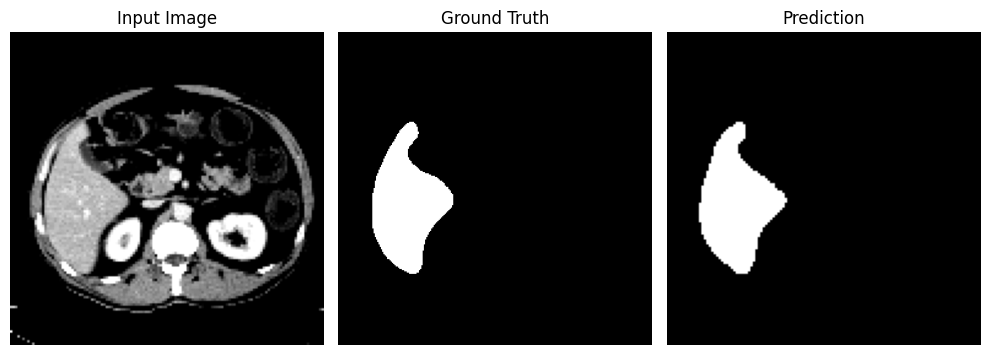

In [27]:
best_dice = 0

with open(log_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=log_fields)
    writer.writeheader()

for current_epoch in range(num_epochs):
    print(f"\n=== Epoch {current_epoch+1} ===")
    best_dice = run_one_epoch(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        epoch=current_epoch,
        best_dice=best_dice,
        save_path="/kaggle/working/trained_unet.pt",
        checkpoint_path="/kaggle/working/last_checkpoint.pt",
        log_file=log_file,
        log_fields=log_fields
    )
visualize_prediction(model, 4, 63)

In [28]:
baseline = model

## To test the model

In [29]:
##model = UNet().to(device) 
##model.load_state_dict(torch.load("/kaggle/input/unet_liver/other/default/1/trained_unet.pt"))
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [30]:
test_metrics = {'loss': 0.0, 'dice_score': 0.0, 'iou_score': 0.0, 'precision': 0.0, 'recall': 0.0}

with torch.no_grad():
    test_iterator = tqdm(test_dataloader, desc="Test", leave=False)
    for inputs, masks in test_iterator:
        inputs, masks = inputs.to(device, non_blocking=True), masks.to(device)
        
        logits = model(inputs)

        probs  = torch.sigmoid(logits)
        metrics = compute_metrics(probs, masks)

        
        loss = criterion(logits, masks).item()
        test_metrics['loss'] += loss
        test_metrics['dice_score'] += metrics['dice_score']
        test_metrics['iou_score'] += metrics['iou_score']
        test_metrics['precision'] += metrics['precision']
        test_metrics['recall'] += metrics['recall']

# Average the metrics over the test dataset
num_batches = len(test_dataloader)
test_metrics = {k: v / num_batches for k, v in test_metrics.items()}

# Print the metrics
print("Test Metrics:")
print(f"Loss: {test_metrics['loss']:.4f}")
loss_final = test_metrics['dice_score']
print(f"Dice Score: {loss_final:.4f}")
print(f"IoU: {test_metrics['iou_score']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")

Test Metrics:
Loss: 0.0035
Dice Score: 0.9762
IoU: 0.9448
Precision: 0.9689
Recall: 0.9744


## Attention U‑Net Extension

we augment our standard U‑Net with Attention Gates. Attention gates learn to weight encoder 
features before concatenation, focusing the decoder on relevant regions 
(for example small tumors) and suppressing background noise.

1. AttentionBlock: computes a soft attention mask from decoder and encoder features.  
2. AttentionUNet class: same contracting/expanding paths as U‑Net, but each skip‑connection is gated.  
3. Integration: instantiate AttentionUNet, replace the old model, and retrain.  


In [31]:
#conv_block Utility (Two 3×3 convolutions with ReLU, same as in the original U‑Net..)
def conv_block(in_channels: int, out_channels: int) -> nn.Sequential:
    return nn.Sequential(
        nn.Conv2d(in_channels,  out_channels, kernel_size=3, padding=1),  # conv 1   :contentReference[oaicite:0]{index=0}
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # conv 2   :contentReference[oaicite:1]{index=1}
        nn.ReLU(inplace=True)
    )

In [32]:
# Attention Gate Module

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        F_g: # decoder feature channels, F_l: # encoder feature channels
        F_int: intermediate channels for gating
        """
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int),
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int),
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        g: gating signal from decoder (smaller spatial dims)
        x: encoder features
        returns: gated encoder features
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


In [33]:
# Attention U‑Net Architecture 
class AttentionUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        # Encoder
        self.enc1 = conv_block(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder + Attention
        self.up4  = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = conv_block(1024, 512)

        self.up3  = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = conv_block(512, 256)

        self.up2  = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = conv_block(256, 128)

        self.up1  = nn.ConvTranspose2d(128,  64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64,  F_l=64,  F_int=32)
        self.dec1 = conv_block(128,  64)

        # Final conv
        self.final = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        # Encode
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))

        # Bottleneck
        x5 = self.bottleneck(self.pool4(x4))

        # Decode + Attention
        g4 = self.up4(x5)
        x4 = self.att4(g4, x4)
        d4 = self.dec4(torch.cat([g4, x4], dim=1))

        g3 = self.up3(d4)
        x3 = self.att3(g3, x3)
        d3 = self.dec3(torch.cat([g3, x3], dim=1))

        g2 = self.up2(d3)
        x2 = self.att2(g2, x2)
        d2 = self.dec2(torch.cat([g2, x2], dim=1))

        g1 = self.up1(d2)
        x1 = self.att1(g1, x1)
        d1 = self.dec1(torch.cat([g1, x1], dim=1))

        return self.final(d1)


### Instantiate & Train Attention U‑Net

Now we swap in the new model class, re‑initialize the optimizer, and run the training loop exactly as before:


In [34]:
#replacing the model
model = AttentionUNet(in_ch=1, out_ch=config.n_classes).to(device)

#re‐init optimizer & criterion
criterion = nn.functional.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

#retrain
best_dice = 0
log_file = "attnunet_train_log.csv"
with open(log_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=log_fields)
    writer.writeheader()

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} (Attention U‑Net) ===")
    best_dice = run_one_epoch(
        model, optimizer, criterion,
        train_dataloader, test_dataloader,
        epoch, best_dice,
        save_path="/kaggle/working/attn_unet.pt",
        checkpoint_path="/kaggle/working/attn_checkpoint.pt",
        log_file=log_file, log_fields=log_fields
    )



=== Epoch 1/8 (Attention U‑Net) ===


Epoch 1: 100%|██████████| 252/252 [10:33<00:00,  2.51s/it, bce_loss=0.0931, dice_score=0.7619, iou_score=0.4373, precision=0.6053, recall=0.4991]


Epoch 1: New best model saved with Dice 0.8841

=== Epoch 2/8 (Attention U‑Net) ===


Epoch 2: 100%|██████████| 252/252 [10:36<00:00,  2.52s/it, bce_loss=0.0142, dice_score=0.9010, iou_score=0.8062, precision=0.9078, recall=0.8793]


Epoch 2: New best model saved with Dice 0.9275

=== Epoch 3/8 (Attention U‑Net) ===


Epoch 3: 100%|██████████| 252/252 [10:36<00:00,  2.53s/it, bce_loss=0.0102, dice_score=0.9275, iou_score=0.8573, precision=0.9286, recall=0.9185]


Epoch 3: New best model saved with Dice 0.9435

=== Epoch 4/8 (Attention U‑Net) ===


Epoch 4: 100%|██████████| 252/252 [10:37<00:00,  2.53s/it, bce_loss=0.0069, dice_score=0.9491, iou_score=0.8991, precision=0.9498, recall=0.9443]



=== Epoch 5/8 (Attention U‑Net) ===


Epoch 5: 100%|██████████| 252/252 [10:35<00:00,  2.52s/it, bce_loss=0.0053, dice_score=0.9599, iou_score=0.9212, precision=0.9607, recall=0.9575]


Epoch 5: New best model saved with Dice 0.9663

=== Epoch 6/8 (Attention U‑Net) ===


Epoch 6: 100%|██████████| 252/252 [10:36<00:00,  2.53s/it, bce_loss=0.0043, dice_score=0.9699, iou_score=0.9349, precision=0.9673, recall=0.9656]


Epoch 6: New best model saved with Dice 0.9757

=== Epoch 7/8 (Attention U‑Net) ===


Epoch 7: 100%|██████████| 252/252 [10:39<00:00,  2.54s/it, bce_loss=0.0036, dice_score=0.9766, iou_score=0.9446, precision=0.9721, recall=0.9710]



=== Epoch 8/8 (Attention U‑Net) ===


Epoch 8: 100%|██████████| 252/252 [10:42<00:00,  2.55s/it, bce_loss=0.0050, dice_score=0.9590, iou_score=0.9264, precision=0.9635, recall=0.9602]


In [35]:
attn_net = model

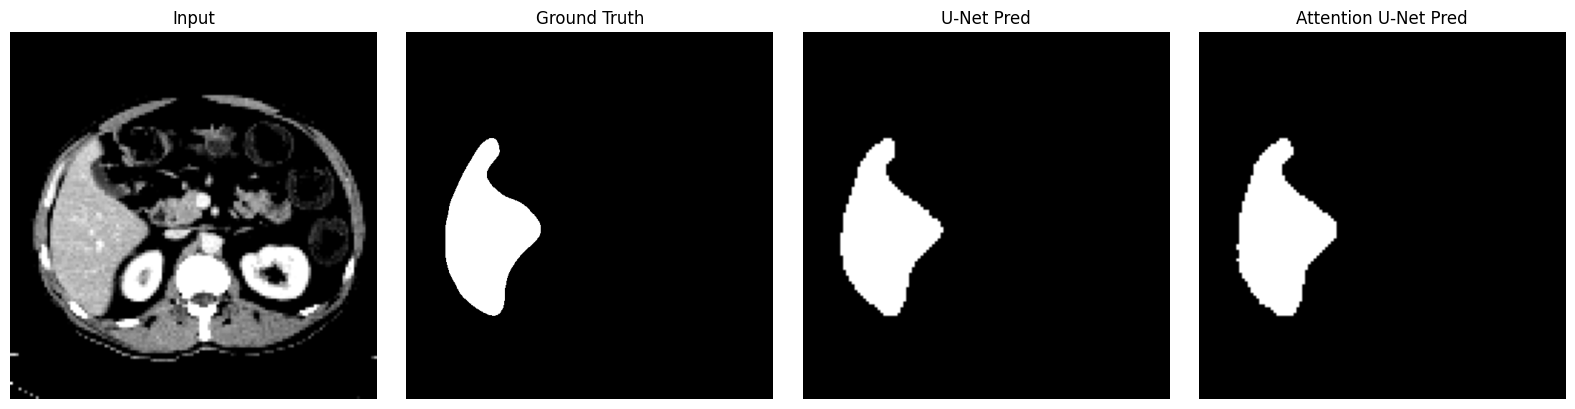

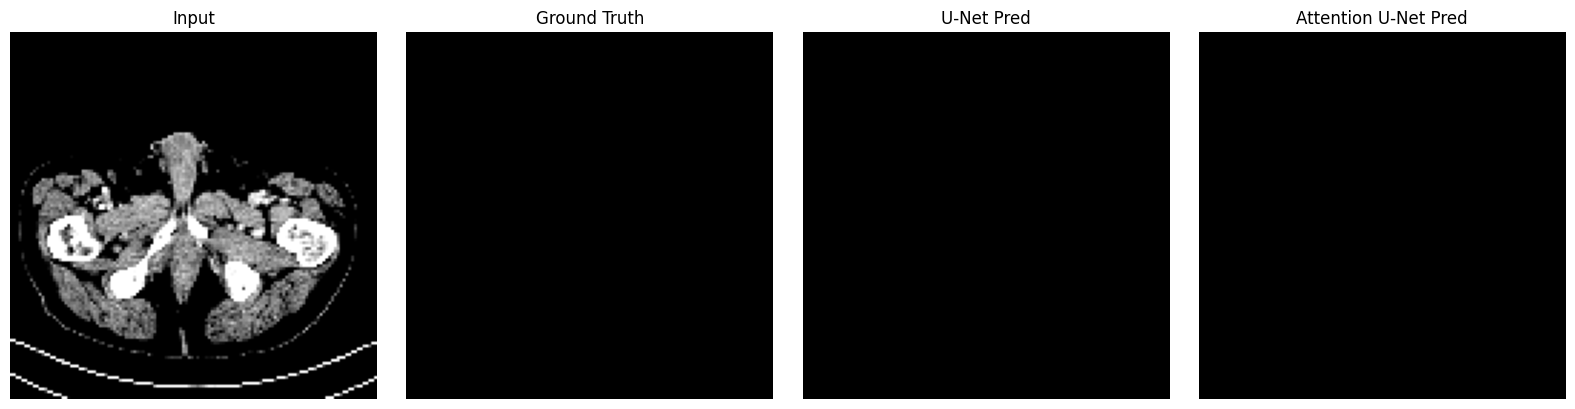

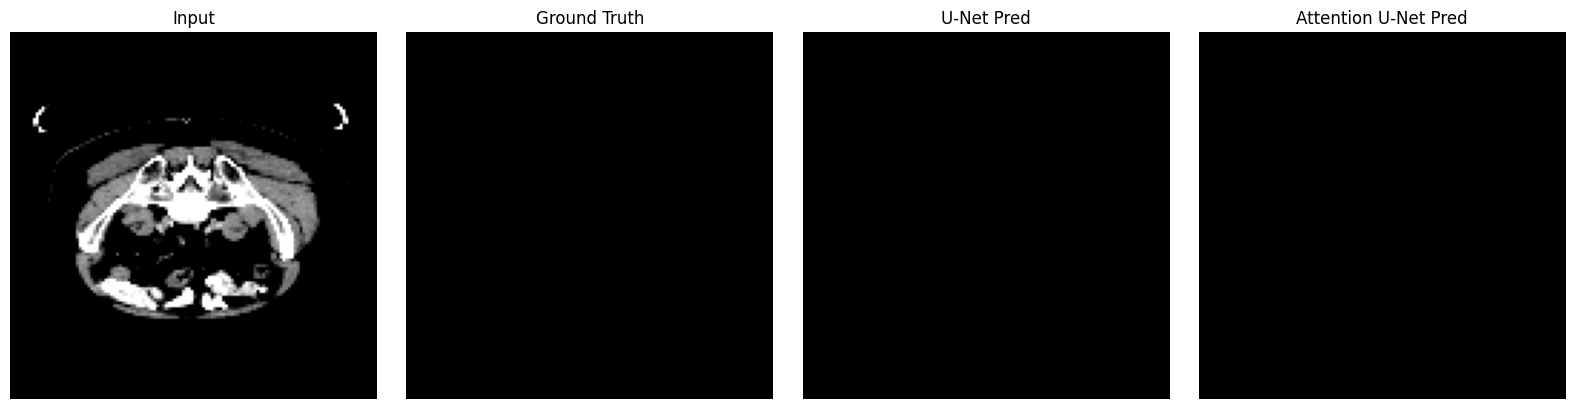

In [36]:
#Visual Comparison on Test Slices 

def show_comparison(model1, model2, volume_paths, seg_paths, indices=[0,1,2], orientation=63):
    """
    model1, model2: two trained nn.Modules
    indices: list of volume indices to display
    """
    model1.eval()
    model2.eval()
    for idx in indices:
        img = nib.load(volume_paths[idx]).get_fdata().transpose(2,1,0)[orientation]
        mask = nib.load(seg_paths[idx]).get_fdata().transpose(2,1,0)[orientation]
        
        inp = preprocessing(img)
        tensor = torch.tensor(inp, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        
        with torch.no_grad():
            out1 = torch.sigmoid(model1(tensor)).cpu().squeeze().numpy()
            out2 = torch.sigmoid(model2(tensor)).cpu().squeeze().numpy()
        
        fig, axes = plt.subplots(1,4,figsize=(16,4))
        axes[0].imshow(inp, cmap='gray');           axes[0].set_title("Input")
        axes[1].imshow(mask, cmap='gray');          axes[1].set_title("Ground Truth")
        axes[2].imshow(out1>0.5, cmap='gray');      axes[2].set_title("U‑Net Pred")
        axes[3].imshow(out2>0.5, cmap='gray');      axes[3].set_title("Attention U‑Net Pred")
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

## load saved models
#baseline = UNet().to(device)
#baseline.load_state_dict(torch.load("/kaggle/working/trained_unet.pt"))
#attn_net  = AttentionUNet().to(device)
#attn_net.load_state_dict(torch.load("/kaggle/working/attn_unet.pt"))

show_comparison(baseline, attn_net, config.volume_paths, config.seg_paths, indices=[4,5,6])


### ->  The segmentation accuracy for both models is satisfying.. the completely black rows just mean that for those particular slices, the tumor mask is empty so both our GT and the two models’ predictions are all zeros (ie 100% background)

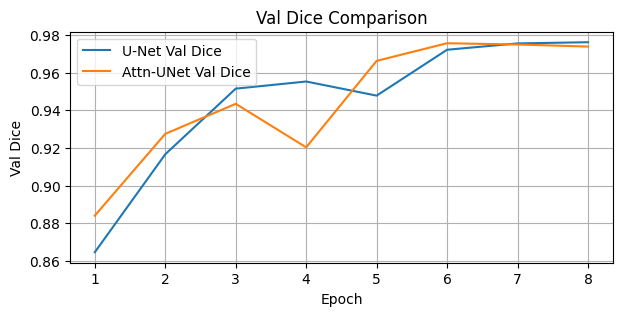

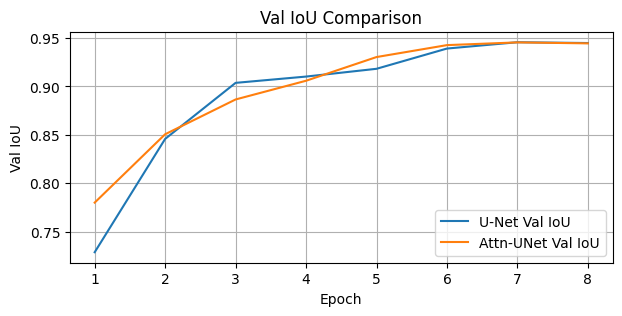

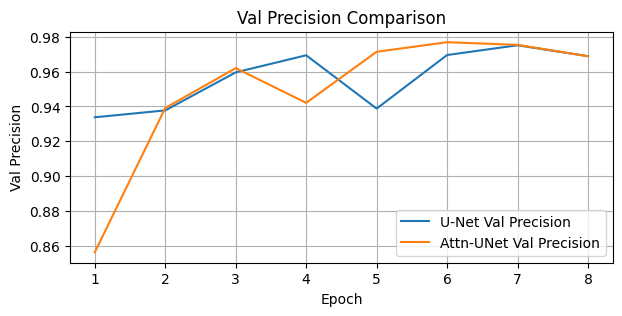

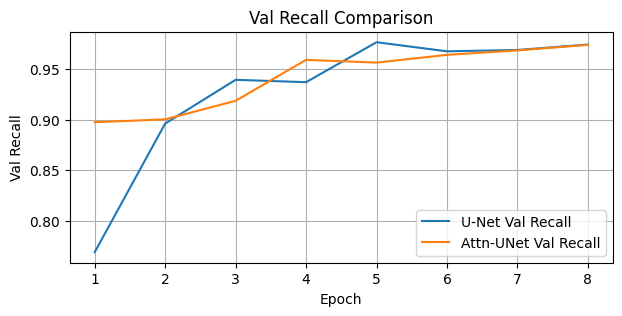

In [37]:
df_u  = pd.read_csv("unet_train_log.csv")
df_a  = pd.read_csv("attnunet_train_log.csv")

epochs = df_u['epoch'] + 1

#plot metrics
for metric, name in [
    ('dice_val', 'Val Dice'),
    ('mIou_val', 'Val IoU'),
    ('precision_val', 'Val Precision'),
    ('recall_val', 'Val Recall')
]:
    plt.figure(figsize=(7,3))
    plt.plot(epochs, df_u[metric],  label=f"U‑Net {name}")
    plt.plot(epochs, df_a[metric],  label=f"Attn‑UNet {name}")
    plt.xlabel("Epoch"); plt.ylabel(name)
    plt.title(name + " Comparison")
    plt.legend(); plt.grid(True)
    plt.show()


### -> Convergence plus rapide
Dès la première epoch l’Attention U‑Net démarre avec un Dice et un IoU plus élevés que le U‑Net « nu ». Ses courbes grimpent plus vite entre les époques 1 et 3, ce qui signifie qu’il apprend plus rapidement à localiser la lésion..

### ->Gain modeste en performance finale
En epoch tardives (6–8) les deux modèles plafonnent autour de 0.97–0.98 de Dice et ~0.94–0.95 d’IoU. L’écart final est faible (quelques millièmes), çq suggère que l’attention aide à converger plus vite, mais l'amélioration qu'elle apporte reste marginale sur ce jeu de validation en fin d’entraînement..

### ->Impact sur les métriques de rappel
le « Val Recall » que l’Attention U‑Net commence déjà très haut (~0.90) alors que le U‑Net classique n’atteint ce niveau qu’à l’epoch2. Pour des applications où le rappel (ne pas manquer un cas positif) est critique, ce démarrage plus fort peut être un atout..